# Scaling up GNNs with GraphSAGE

In [1]:
# Download Pubmed dataset
from torch_geometric.datasets import Planetoid

# get pubmed dataset
dataset = Planetoid(root='.', name='Pubmed')
data = dataset[0]

# dataset information
print(f"dataset name {dataset}")
print(f"number of graphs {len(dataset)}")
print(f"number of features {dataset.num_features}")
print(f"number of classes {dataset.num_classes} \n")

# graph information
print(f"number of nodes {data.x.shape[0]}")
print(f"number of training nodes {len(data.train_mask)}")
print(f"number of validation nodes {len(data.val_mask)}")
print(f"number of test nodes {len(data.test_mask)}")
print(f"graph has isolated nodes {data.has_isolated_nodes()}")
print(f"graph has self loop {data.has_self_loops()}")

dataset name Pubmed()
number of graphs 1
number of features 500
number of classes 3 

number of nodes 19717
number of training nodes 19717
number of validation nodes 19717
number of test nodes 19717
graph has isolated nodes False
graph has self loop False


In [2]:
# create dataloader
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

BATCH_SIZE = 16

# create batches with neighbor sampling
train_dataloader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=BATCH_SIZE,
    input_nodes=data.train_mask
)

# print dataloader info
for batch, loader in enumerate(train_dataloader):
    print(f"{batch}: {loader}")

0: Data(x=[382, 500], edge_index=[2, 441], y=[382], train_mask=[382], val_mask=[382], test_mask=[382], input_id=[16], batch_size=16)
1: Data(x=[263, 500], edge_index=[2, 308], y=[263], train_mask=[263], val_mask=[263], test_mask=[263], input_id=[16], batch_size=16)
2: Data(x=[280, 500], edge_index=[2, 314], y=[280], train_mask=[280], val_mask=[280], test_mask=[280], input_id=[16], batch_size=16)
3: Data(x=[195, 500], edge_index=[2, 226], y=[195], train_mask=[195], val_mask=[195], test_mask=[195], input_id=[12], batch_size=12)


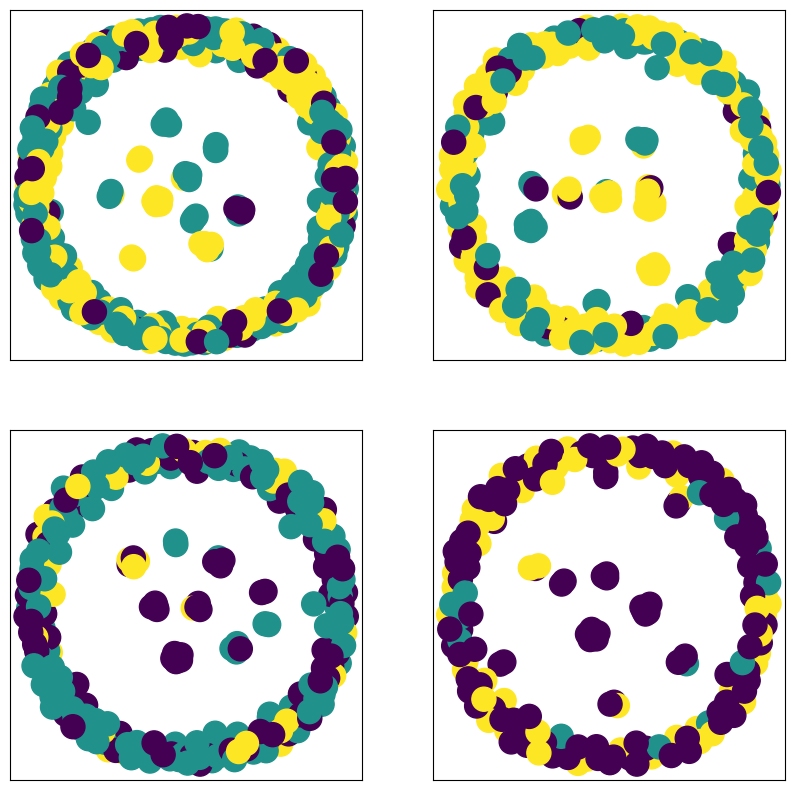

In [3]:
# visualize dataloaders
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
for batch, loader in enumerate(train_dataloader):
    G = to_networkx(loader, to_undirected=True)
    ax = fig.add_subplot(2, 2, batch+1)
    nx.draw_networkx(G, with_labels=False, node_color=loader.y)

In [4]:
# setup GraphSAGE class
import torch
from torch import nn
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in: int, dim_h: int, dim_out:int):
        super().__init__()
        self.sage1 = SAGEConv(in_channels=dim_in, out_channels=dim_h)
        self.sage2 = SAGEConv(in_channels=dim_h, out_channels=dim_out)
    def forward(self, x:torch.Tensor, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = nn.functional.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

In [5]:
# create GraphSAGE model
model = GraphSAGE(
    dim_in=dataset.num_features,
    dim_h = 64,
    dim_out = dataset.num_classes
)
model

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)

In [6]:
# setup train step function
from sources.metrics import accuracy

def train_loader_step(model:torch.nn.Module,
              dataloader: NeighborLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):

    # initialize train loss, accuracy
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    for batch in dataloader:
        # forward step
        y_logit = model(batch.x, batch.edge_index)
        # training loss
        loss = loss_fn(y_logit[batch.train_mask], batch.y[batch.train_mask])
        # accumulate train loss of dataloader
        train_loss += loss.item()
        # accumulate training accuracy
        train_acc += accuracy(y_logit[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask]).item()
        # zero out gradient
        optimizer.zero_grad()
        # back probagation
        loss.backward()
        # optimizer step
        optimizer.step()
        
        # validation
        val_loss += loss_fn(y_logit[batch.val_mask], batch.y[batch.val_mask]).item()
        val_acc += accuracy(y_logit[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask]).item()
    # averaging train and validation loss and accuracy
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    # return train and validation loss and accuracy
    return train_loss, train_acc, val_loss, val_acc

In [7]:
# setup train function
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
         dataloader: NeighborLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epochs=10):

    # switch to train step
    model.train()

    results = {
        'train_loss': [],
        'train_acc' : [],
        'val_loss'  : [],
        'val_acc'   : []
    }
    
    # loop over epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, val_loss, val_acc = train_loader_step(
            model=model,
            dataloader=dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

    return results

In [8]:
# setup test function
import torch_geometric
def test(model: torch.nn.Module,
        data: torch_geometric.data.data.Data):
    
    # switch to evaluation mode
    model.eval()
    # test forward pass
    test_logit = model(data.x, data.edge_index)
    test_acc = accuracy(test_logit.argmax(dim=1)[data.test_mask], data.y[data.test_mask]).item()
    return test_acc

In [9]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)

In [10]:
results = train(
    model=model,
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=200
)

  0%|          | 0/200 [00:00<?, ?it/s]

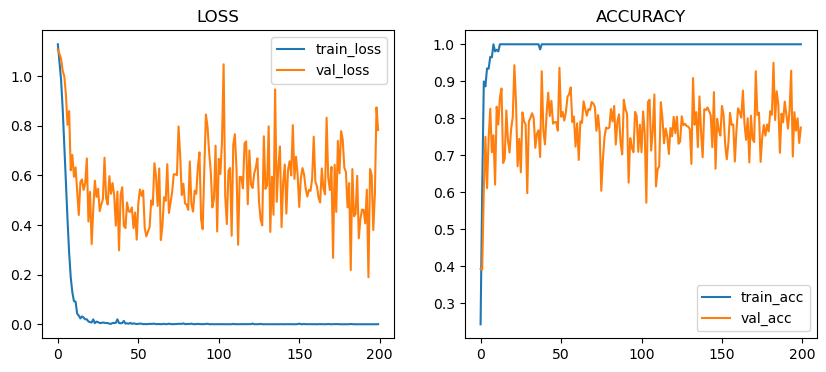

In [11]:
from sources.utils import visualize_results

visualize_results(results=results)

In [12]:
# compute test accuracy
test_acc = test(
    model=model,
    data=data
)
print(f"test accuracy: {test_acc*100:.1f}(%)")

test accuracy: 76.7(%)
